# Optimizing Election Campaigning Strategy by Locating Persuadable Voters
In recent presidential elections, the majority of voters know whom they will vote for months in advance. It is therefore a waste of time and money for candidates to try and persuade these voters to their side. The goal of this project is to find locations where there are many people who are more likely to be persuaded one way or another - people who are open to voting for either candidate. These are the voters that candidates need to reach out to in order to win the election.

This MVP will identify precincts in Minnesota where there are relatively large numbers of 'split ticket' ballots. That is, ballots where a voter might have chosen a Republican candidate for president but a Democratic candidate for U.S. House. People who split their ballot are less loyal to a particular party, so they would therefore be more likely to change their mind to support or oppose a political candidate based on that candidate's campaign. These 'split ticket' voters are people whom candidates should target because they are key to winning an election.

#### Install required package and import libraries

In [11]:
!pip install mapclassify
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import numpy as np
import mapclassify
import csv
%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\adols\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


#### Read MN Precincts GeoJSON file. This file contains the geometries for each precinct in the state of Minnesota, as well as additional information such as which county the precinct is in.

In [12]:
mn_precincts_gdb = gpd.read_file('mn_precincts_2019.json')
mn_precincts_gdb.head()

,Precinct,PrecinctID,County,CountyID,CongDist,MNSenDist,MNLegDist,CtyComDist,geometry
0,Aitkin,270010005,Aitkin,1,8,10,10B,1,"POLYGON ((-93.6863 46.5441, -93.6916 46.5441, ..."
1,Aitkin Twp,270010010,Aitkin,1,8,10,10B,1,"MULTIPOLYGON (((-93.7052 46.5163, -93.7061 46...."
2,Ball Bluff Twp,270010015,Aitkin,1,8,10,10B,5,"POLYGON ((-93.1911 47.0252, -93.2118 47.0255, ..."
3,Balsam Twp,270010020,Aitkin,1,8,10,10B,5,"POLYGON ((-93.0598 46.853, -93.081 46.8528, -9..."
4,Beaver Twp,270010025,Aitkin,1,8,10,10B,3,"POLYGON ((-93.0551 46.4191, -93.0554 46.4336, ..."


#### Function to extract voting information from a csv file

In [13]:
'''
data is the csv file containing precinct-level voter data
gdb is the GeoDataFrame containing precinct geometries
list_of_indices contains three elements. These elements contain the column numbers of the csv file that contain:
    0) the total number of votes for this race in the precinct
    1) the number of Republican votes for this race in the precinct
    2) the number of Democratic votes for this race in the precinct

return value: a list that contains three lists. Each list is the same length as the GeoDataFrame so that it can be added to the GeoDataFrame.
    total_voters_list contains the total number of votes cast in each precinct
    pct_rep_votes_list contains the percentage of those votes that were cast for the Republican candidate
    pct_dem_votes_list contains the percentage of those votes that were cast for the Democratic candidate
'''

def create_voter_lists(data, gdb, list_of_indices):
  total_voters_list = []
  pct_rep_votes_list = []
  pct_dem_votes_list = []
  for row in gdb.itertuples():     # iterate over each precinct in the GeoDataFrame
    precinct_id = row[2]          # extract precinct code
    voter_data = False            # use this boolean to speed up the search process
    for row in data:              # search the list of voting results to see if this precinct has voter data
      if voter_data == False:     # if we have already found voter data (i.e. voter_data == True), we don't need to keep iterating through the list of data
        if row[0] == precinct_id:     # if the precinct has voter data, append this data to the 2 lists
          total_votes = int(row[list_of_indices[0]])
          rep_votes = int(row[list_of_indices[1]])
          dem_votes = int(row[list_of_indices[2]])
          total_voters_list.append(total_votes)
          if total_votes != 0:
            pct_rep_votes_list.append((rep_votes / total_votes) * 100)
            pct_dem_votes_list.append((dem_votes / total_votes) * 100)
          else:
            pct_rep_votes_list.append(0)
            pct_dem_votes_list.append(0)
          voter_data = True
    if voter_data == False:       # if there is no voter data available, we need to take note of this
      pct_rep_votes_list.append(None)
      pct_dem_votes_list.append(None)

  return [total_voters_list, pct_rep_votes_list, pct_dem_votes_list]

#### Add voting information to each precinct in the GeoDataFrame.

In [14]:
with open('mn_precinct_results_2020.csv', newline='') as csvfile:
  mn_precinct_results = csv.reader(csvfile, delimiter=',', quotechar='"')     # this csv file contains Minnesota's precinct-level results from the 2020 election
  next(mn_precinct_results, None)     # skip the header
  precinct_data = list(mn_precinct_results)    # convert the csv reader object into a list where each element is itself a list, and the elements of these lists are the columns of the csv files

# retrieve info for presidential race and add this data to the GeoDataFrame
pres_results_list = create_voter_lists(precinct_data, mn_precincts_gdb, [36, 26, 27])
mn_precincts_gdb.insert(8, 'pres_total_votes', pres_results_list[0], True)
mn_precincts_gdb.insert(9, 'pres_pct_rep_votes', pres_results_list[1], True)
mn_precincts_gdb.insert(10, 'pres_pct_dem_votes', pres_results_list[2], True)

# retrieve info for U.S. Senate race and add this data to the GeoDataFrame
senate_results_list = create_voter_lists(precinct_data, mn_precincts_gdb, [42, 39, 40])
mn_precincts_gdb.insert(11, 'sen_total_votes', senate_results_list[0], True)
mn_precincts_gdb.insert(12, 'sen_pct_rep_votes', senate_results_list[1], True)
mn_precincts_gdb.insert(13, 'sen_pct_dem_votes', senate_results_list[2], True)

# retrieve info for U.S. House races and add this data to the GeoDataFrame
house_results_list = create_voter_lists(precinct_data, mn_precincts_gdb, [48, 45, 46])
mn_precincts_gdb.insert(14, 'house_total_votes', house_results_list[0], True)
mn_precincts_gdb.insert(15, 'house_pct_rep_votes', house_results_list[1], True)
mn_precincts_gdb.insert(16, 'house_pct_dem_votes', house_results_list[2], True)

mn_precincts_gdb.head()

,Precinct,PrecinctID,County,CountyID,CongDist,MNSenDist,MNLegDist,CtyComDist,pres_total_votes,pres_pct_rep_votes,pres_pct_dem_votes,sen_total_votes,sen_pct_rep_votes,sen_pct_dem_votes,house_total_votes,house_pct_rep_votes,house_pct_dem_votes,geometry
0,Aitkin,270010005,Aitkin,1,8,10,10B,1,1091,57.378552,40.879927,1067,51.077788,39.456420,1054,55.218216,37.571157,"POLYGON ((-93.6863 46.5441, -93.6916 46.5441, ..."
1,Aitkin Twp,270010010,Aitkin,1,8,10,10B,1,576,65.798611,32.465278,566,64.134276,30.212014,564,68.085106,26.595745,"MULTIPOLYGON (((-93.7052 46.5163, -93.7061 46...."
2,Ball Bluff Twp,270010015,Aitkin,1,8,10,10B,5,185,57.837838,40.540541,181,52.486188,43.646409,182,57.142857,37.912088,"POLYGON ((-93.1911 47.0252, -93.2118 47.0255, ..."
3,Balsam Twp,270010020,Aitkin,1,8,10,10B,5,24,50.000000,45.833333,24,54.166667,45.833333,24,54.166667,45.833333,"POLYGON ((-93.0598 46.853, -93.081 46.8528, -9..."
4,Beaver Twp,270010025,Aitkin,1,8,10,10B,3,38,44.736842,52.631579,36,44.444444,55.555556,36,41.666667,52.777778,"POLYGON ((-93.0551 46.4191, -93.0554 46.4336, ..."


#### Find precincts where there might have been many split ballots, e.g. people might vote for the Republican presidential candidate but also vote for a Democratic candidate for the House

To accomplish this, we will calculate a statistical measure for each precinct. The score will be calculated using the following equation, which is a standard method for measuring error. In this case, we are not measuring error but rather the discrepency between how a precinct voted for president vs. how they voted in the U.S. Senate and House races. The equation is `(p - mean(s + h))^2`. `p` is the percentage of the precinct that voted for the Democratic candidate for president, `s` is the percentage of the precinct that voted for the Democratic candidate for Senate, and `h` is the percentage of the precinct that voted for the Democratic candidate for the House. This score measures the squared difference between `p` and the mean of `s` and `h`. Higher scores represent precincts that had a higher percentage of 'split ticket' ballots.

In [15]:
squared_diff_list = []   # list to append to the GeoDataFrame; this list contains the squared differences
analysis_list = []  # list on which to run analysis; each element is a list of three values - the squared differences, the county name where the precinct is located, and the total number of votes cast in the Presidential race in that precinct
for index, row in mn_precincts_gdb.iterrows():
  avg_dem_congress_vote = (row['sen_pct_dem_votes'] + row['house_pct_dem_votes']) / 2
  squared_diff = (row['pres_pct_dem_votes'] - avg_dem_congress_vote) ** 2
  squared_diff_list.append(squared_diff)
  analysis_list.append([squared_diff, row['County'], row['pres_total_votes']])


mn_precincts_gdb.insert(17, "squared_differences", squared_diff_list, True)
mn_precincts_gdb.head()

,Precinct,PrecinctID,County,CountyID,CongDist,MNSenDist,MNLegDist,CtyComDist,pres_total_votes,pres_pct_rep_votes,pres_pct_dem_votes,sen_total_votes,sen_pct_rep_votes,sen_pct_dem_votes,house_total_votes,house_pct_rep_votes,house_pct_dem_votes,squared_differences,geometry
0,Aitkin,270010005,Aitkin,1,8,10,10B,1,1091,57.378552,40.879927,1067,51.077788,39.456420,1054,55.218216,37.571157,5.598609,"POLYGON ((-93.6863 46.5441, -93.6916 46.5441, ..."
1,Aitkin Twp,270010010,Aitkin,1,8,10,10B,1,576,65.798611,32.465278,566,64.134276,30.212014,564,68.085106,26.595745,16.494957,"MULTIPOLYGON (((-93.7052 46.5163, -93.7061 46...."
2,Ball Bluff Twp,270010015,Aitkin,1,8,10,10B,5,185,57.837838,40.540541,181,52.486188,43.646409,182,57.142857,37.912088,0.056981,"POLYGON ((-93.1911 47.0252, -93.2118 47.0255, ..."
3,Balsam Twp,270010020,Aitkin,1,8,10,10B,5,24,50.000000,45.833333,24,54.166667,45.833333,24,54.166667,45.833333,0.000000,"POLYGON ((-93.0598 46.853, -93.081 46.8528, -9..."
4,Beaver Twp,270010025,Aitkin,1,8,10,10B,3,38,44.736842,52.631579,36,44.444444,55.555556,36,41.666667,52.777778,2.356494,"POLYGON ((-93.0551 46.4191, -93.0554 46.4336, ..."


#### Select the precincts in the top 20% for their squared difference score. These precincts have the highest percentage of 'split ticket' ballots.

In [16]:
twenty_pct = round(len(analysis_list) / 5)      # calculate the number of precincts to select - in this case, 20% of the total number of precincts in MN
analysis_list.sort()                            # sort the list in ascending order by squared difference
twenty_pct_list = analysis_list[-twenty_pct:]   # select the top 20% of the precincts with regards to squared difference

#### Precincts are small. Candidates should spend their time in counties that contain lots of precincts of interest. If a county just has 1 or 2 precincts with many 'split ticket' voters, it may not be worth it for the candidate to spend a lot of time there. Rather, they want to travel to locations where there are lots of these precincts.

Find the counties in Minnesota that contain the highest number of voters who live in these 'split ticket' precincts. Candidates should spend their time in these counties to maximize the number of 'split ticket' voters that they can interact with. Now, not everyone in these precincts is persuadable. Rather, these counties contain higher quantities of persuadable voters in total, even if these voters are thoroughly mixed in with already-decided voters.

In [17]:
county_dict = {}                # each key is a county, and the values are the number of voters who live in precincts in these counties that have been identified above as high 'split ticket' precincts
for row in twenty_pct_list:
  county = row[1]
  total_votes = row[2]
  if county in county_dict:
    county_dict[county] += total_votes
  else:
    county_dict[county] = total_votes

##### Turn the county dictionary into a list so that it can be sorted. Then, extract the top 10 counties from this dictionary with regards to the number of voters who live in high 'split ticket' precincts within these counties.

In [18]:
county_list = []
for key, value in county_dict.items():
  county_list.append([value, key])
county_list.sort()
for i in range(len(county_list) - 1, len(county_list) - 11, -1):
  print(f'{county_list[i][1]} county has {county_list[i][0]} voters who live in high \'split ticket\' precincts.')

Hennepin county has 362803 voters who live in high 'split ticket' precincts.
Ramsey county has 39574 voters who live in high 'split ticket' precincts.
Anoka county has 32913 voters who live in high 'split ticket' precincts.
St. Louis county has 17130 voters who live in high 'split ticket' precincts.
Dakota county has 4240 voters who live in high 'split ticket' precincts.
Polk county has 4141 voters who live in high 'split ticket' precincts.
Beltrami county has 4054 voters who live in high 'split ticket' precincts.
Marshall county has 3848 voters who live in high 'split ticket' precincts.
Renville county has 2925 voters who live in high 'split ticket' precincts.
Stearns county has 2889 voters who live in high 'split ticket' precincts.


<Axes: >

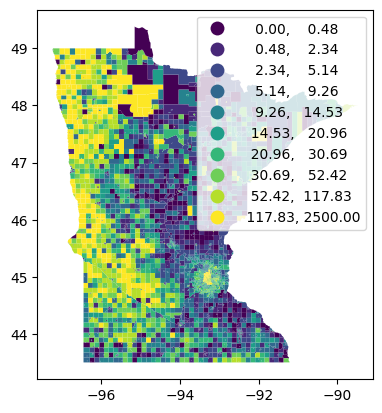

In [19]:
mn_precincts_gdb.plot(column='squared_differences', scheme='Quantiles', k=10, legend=True)

This notebook represents an MVP of my project for many reasons. For one, it only analyzes Minnesota. Presidential candidates are obviously interested in the entire U.S., but analyzing the entire country would have been too much for this MVP. Additionally, there are many other factors besides 'split ticket' voters that determine if someone is willing to vote for either candidate. Another big indicator of this is how many people are registered as Democratic voters vs. Republican voters vs. independent voters. People are not registered with a specific party are of high interest to presidential candidates, but my MVP did not look at these people. However, my MVP did provide a start towards the robust solution for this project, and with more time to analyze the entire country and more variables, it would be possible to create a more detailed guide for candidates on where they would be best suited to spend their time campaigning.

#### Credits

2020 Presidential election results by precinct in Minnesota:
https://www.sos.state.mn.us/elections-voting/election-results/2020/2020-general-election-results/2020-precinct-results-spreadsheet/

2019 Minnesota voting precincts GeoJSON (I had to use Web Archive because the current GeoJSON file available on the MN Secretary of State’s website has 2024 precincts, some of which have changed since 2020):
https://web.archive.org/web/20210510102449/https://www.sos.state.mn.us/media/2791/mn-precincts.json
